In [1]:
import cv2
from PIL import Image
import numpy as np
data_path = "..\\dataset\\classifer\\train\\Black-grass\\adwstlhujk.png"
# data_path = "..\\dataset\classifer\\train\Charlock\\anctmubvdy.png"

In [ ]:
img = Image.open(data_path)
img

In [2]:
# 图像均衡化
def equalize(image):
    # 分割B,G,R （cv2读取图像的格式即为[B,G,R]，与matplotlib的[R,G,B]不同）
    b,g,r = cv2.split(image)
    b = cv2.equalizeHist(b)
    g = cv2.equalizeHist(g)
    r = cv2.equalizeHist(r)
    equ_img = cv2.merge((b,g,r))
    return equ_img

In [5]:
import numpy as np
import math
 
def stretchImage(data, s=0.005, bins = 2000):    #线性拉伸，去掉最大最小0.5%的像素值，然后线性拉伸至[0,1]
    ht = np.histogram(data, bins)
    d = np.cumsum(ht[0])/float(data.size)
    lmin = 0; lmax=bins-1
    while lmin<bins:
        if d[lmin]>=s:
            break
        lmin+=1
    while lmax>=0:
        if d[lmax]<=1-s:
            break
        lmax-=1
    return np.clip((data-ht[1][lmin])/(ht[1][lmax]-ht[1][lmin]), 0,1)
 
def getPara(radius = 5):                        #根据半径计算权重参数矩阵
    g_para = {}
    m = g_para.get(radius, None)
    if m is not None:
        return m
    size = radius*2+1
    m = np.zeros((size, size))
    for h in range(-radius, radius+1):
        for w in range(-radius, radius+1):
            if h==0 and w==0:
                continue
            m[radius+h, radius+w] = 1.0/math.sqrt(h**2+w**2)
    m /= m.sum()
    g_para[radius] = m
    return m
 
def zmIce(I, ratio=4, radius=300):                     #常规的ACE实现
    para = getPara(radius)
    height,width = I.shape
    zh,zw = [0]*radius + [x for x in range(height)] + [height-1]*radius, [0]*radius + [x for x in range(width)]  + [width -1]*radius
    Z = I[np.ix_(zh, zw)]
    res = np.zeros(I.shape)
    for h in range(radius*2+1):
        for w in range(radius*2+1):
            if para[h][w] == 0:
                continue
            res += (para[h][w] * np.clip((I-Z[h:h+height, w:w+width])*ratio, -1, 1))
    return res
 
def zmIceFast(I, ratio, radius):                #单通道ACE快速增强实现
    height, width = I.shape[:2]
    if min(height, width) <=2:
        return np.zeros(I.shape)+0.5
    Rs = cv2.resize(I, ((width+1)//2, (height+1)//2))
    Rf = zmIceFast(Rs, ratio, radius)             #递归调用
    Rf = cv2.resize(Rf, (width, height))
    Rs = cv2.resize(Rs, (width, height))
 
    return Rf+zmIce(I,ratio, radius)-zmIce(Rs,ratio,radius)    
            
def zmIceColor(I, ratio=4, radius=3):               #rgb三通道分别增强，ratio是对比度增强因子，radius是卷积模板半径
    res = np.zeros(I.shape)
    for k in range(3):
        res[:,:,k] = stretchImage(zmIceFast(I[:,:,k], ratio, radius))
    return res

In [7]:
img = cv2.imread(data_path)
cv2.imshow("black-grass", img)
# cv2.waitKey()
# cv2.destroyAllWindows()
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# 线性变换
alpha = 2.0 
lin_img = cv2.convertScaleAbs(img, alpha=alpha, beta=0)
cv2.imshow('Adjusted Contrast', lin_img)
# 直方图均衡化
equ_img = equalize(img)
cv2.imshow('equ', equ_img)
# CLAHE

imgYUV = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
channelsYUV = cv2.split(imgYUV)
t = channelsYUV[0]
 
# 限制对比度的自适应阈值均衡化
clahe = cv2.createCLAHE(clipLimit=6.0, tileGridSize=(8, 8))
p= clahe.apply(t)
 
channels = cv2.merge([p,channelsYUV[1],channelsYUV[2]])
result = cv2.cvtColor(channels, cv2.COLOR_YCrCb2BGR)

# clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8))
# clag_img = clahe.apply(gray_img)
# cla_img = cv2.cvtColor(clag_img, cv2.COLOR_GRAY2RGB)
cv2.imshow('cla', result)

ace_img1 = zmIceColor(img/255.0, ratio=4, radius=3)
cv2.imshow('ace43', ace_img1)
ace_img2 = zmIceColor(img/255.0, ratio=4, radius=5)
cv2.imshow('ace45', ace_img2)
ace_img3 = zmIceColor(img/255.0, ratio=4, radius=7)
cv2.imshow('ace47', ace_img3)
ace_img3 = zmIceColor(img/255.0, ratio=4, radius=9)
cv2.imshow('ace49', ace_img3)
ace_img = zmIceColor(img/255.0, ratio=6, radius=3)
cv2.imshow('ace63', ace_img)
ace_img = zmIceColor(img/255.0, ratio=6, radius=5)
cv2.imshow('ace65', ace_img)
ace_img = zmIceColor(img/255.0, ratio=6, radius=7)
cv2.imshow('ace67', ace_img)
ace_img = zmIceColor(img/255.0, ratio=6, radius=9)
cv2.imshow('ace69', ace_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [11]:
# 创建SIFT特征检测器
sift = cv2.SIFT_create()
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# 特征点提取与描述子生成
kp, des = sift.detectAndCompute(img,None)
print(kp, des)

(< cv2.KeyPoint 000001B20D077BA0>, < cv2.KeyPoint 000001B20B817E70>, < cv2.KeyPoint 000001B20B816820>, < cv2.KeyPoint 000001B20B817390>, < cv2.KeyPoint 000001B20B8179C0>, < cv2.KeyPoint 000001B20B8168E0>, < cv2.KeyPoint 000001B20B8169D0>, < cv2.KeyPoint 000001B20B8174B0>, < cv2.KeyPoint 000001B20B816FD0>, < cv2.KeyPoint 000001B20B8175D0>, < cv2.KeyPoint 000001B20B817CF0>, < cv2.KeyPoint 000001B20B8173F0>, < cv2.KeyPoint 000001B20B817C30>, < cv2.KeyPoint 000001B20B8174E0>, < cv2.KeyPoint 000001B20B817750>, < cv2.KeyPoint 000001B20B817A50>, < cv2.KeyPoint 000001B20B8179F0>, < cv2.KeyPoint 000001B20B817BD0>, < cv2.KeyPoint 000001B20B817810>, < cv2.KeyPoint 000001B20B817B10>, < cv2.KeyPoint 000001B20B817A80>, < cv2.KeyPoint 000001B20B816F10>, < cv2.KeyPoint 000001B20B817F00>, < cv2.KeyPoint 000001B20B816460>, < cv2.KeyPoint 000001B20B817F30>, < cv2.KeyPoint 000001B20B816FA0>, < cv2.KeyPoint 000001B20B816EB0>, < cv2.KeyPoint 000001B20B817510>, < cv2.KeyPoint 000001B20B816AF0>, < cv2.KeyPoin

In [12]:
type(img), img.shape

(numpy.ndarray, (334, 334, 3))

In [13]:
type(des), des.shape

(numpy.ndarray, (342, 128))

In [14]:
cv2.imshow("des", des)
cv2.waitKey()
cv2.destroyAllWindows()

In [15]:
img4show = img.copy()
cv2.drawKeypoints(img, kp, img4show)
cv2.imshow("des", img4show)
cv2.waitKey()
cv2.destroyAllWindows()

In [16]:
# 自适应 阈值锐化
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

med = np.median(gray)
lower = int(max(0, (1.0 - 0.33) * med))
upper = int(min(255, (1.0 + 0.33) * med))
edges = cv2.Canny(gray, lower, upper)

kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
sharp1 = cv2.filter2D(gray, -1, kernel)
sharp2 = cv2.filter2D(edges, -1, kernel)

alpha = 0.5
beta = 1 - alpha
sharped = alpha * sharp1 + beta * sharp2

sharped[sharped>255] = 255
sharped[sharped<0] = 0
sharped = np.uint8(sharped)

cv2.imshow('Sharp Image', sharped)
cv2.waitKey(0)
cv2.destroyAllWindows()

70.0


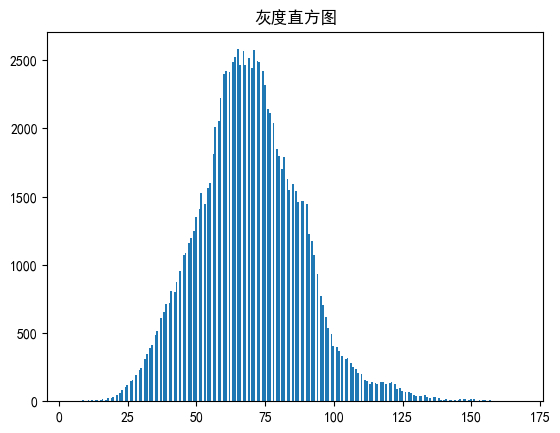

-1

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
img = cv2.imread(data_path, 0)
ret1, th1 = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)  # 简单滤波
ret2, th2 = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU) # Otsu滤波
print(ret2)
cv2.imshow('img', img)
cv2.imshow('th1', th1)
cv2.imshow('th2', th2)
# 解决matplotlib中显示图像的中文乱码问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.hist(img.ravel(), 256)
plt.title('灰度直方图')
plt.show()
cv2.waitKey(0)

In [18]:
# 图像均衡化
def equalize(image):
    # 分割B,G,R （cv2读取图像的格式即为[B,G,R]，与matplotlib的[R,G,B]不同）
    b,g,r = cv2.split(image)
    b = cv2.equalizeHist(b)
    g = cv2.equalizeHist(g)
    r = cv2.equalizeHist(r)
    equ_img = cv2.merge((b,g,r))
    return equ_img

equ_img = equalize(img)
cv2.imshow("equ", equ_img)
cv2.waitKey()
cv2.destroyAllWindows()

ValueError: not enough values to unpack (expected 3, got 1)

In [ ]:
def extractGreen(image):
    # 绿色范围
    lower_green = np.array([35, 43, 46], dtype="uint8")  # 颜色下限
    upper_green = np.array([90, 255, 255], dtype="uint8")  # 颜色上限
    
    # 高斯滤波
    # img_blur = cv2.GaussianBlur(image, (11, 11), 0)
    # 中值滤波
    # img_blur = cv2.medianBlur(image, 11)
    img_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # 根据阈值找到对应颜色，二值化
    mask = cv2.inRange(img_hsv, lower_green, upper_green)
    cv2.imshow("mask", mask)
    cv2.waitKey()
    cv2.destroyAllWindows()
    
    # 按位与
    output = cv2.bitwise_and(image, image, mask=mask)

    return output

ext_img = extractGreen(img)
cv2.imshow("ext", ext_img)
cv2.waitKey()
cv2.destroyAllWindows()

In [ ]:
ext_img_blur = cv2.medianBlur(ext_img, 11)
cv2.imshow("ext", ext_img_blur)
cv2.waitKey()
cv2.destroyAllWindows()

In [ ]:
# 创建SIFT特征检测器
sift_after = cv2.SIFT_create()
# 特征点提取与描述子生成
kp_after, des_after = sift_after.detectAndCompute(ext_img,None)
# print(kp, des)
img4show_after = ext_img.copy()
cv2.drawKeypoints(ext_img, kp_after, img4show_after)
cv2.imshow("des", img4show_after)
cv2.waitKey()
cv2.destroyAllWindows()